In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [3]:
train= pd.read_csv('../data/processed/final_train.csv')
train.head()

,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,home_ownership,verification_status,purpose,...,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,log_annual_inc,fico_score,credit_age_months,credit_age_years,cluster,charged_off
0,11000.0,11000.0,60,14.64,259.62,C,C3,RENT,Source Verified,debt_consolidation,...,65.0,4.0,0.0,4.0,4.698979,687.0,204,17.000000,1,0
1,15000.0,15000.0,36,7.90,469.36,A,A4,MORTGAGE,Verified,debt_consolidation,...,205.0,9.0,1.0,4.0,4.584749,732.0,358,29.833333,1,0
2,10000.0,10000.0,36,10.16,323.43,B,B1,RENT,Not Verified,credit_card,...,33.0,24.0,0.0,4.0,4.690205,732.0,349,29.083333,1,0
3,13000.0,13000.0,36,9.16,414.37,B,B2,RENT,Source Verified,credit_card,...,25.0,8.0,0.0,4.0,5.021193,677.0,219,18.250000,1,0
4,14000.0,14000.0,36,13.67,476.25,B,B5,RENT,Not Verified,debt_consolidation,...,240.0,12.0,1.0,8.0,4.966146,677.0,381,31.750000,1,0


In [6]:
X_train= train.loc[train.cluster == 0].drop(columns=['cluster', 'charged_off'], axis=1)
y_train= train.loc[train.cluster==0]['charged_off']

In [10]:
train.groupby('cluster')['charged_off'].value_counts()

cluster  charged_off
0        0              164120
         1               40464
1        0              288711
         1               77195
Name: count, dtype: int64

In [16]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
models= []
#Linear models
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
models.append(('LGBM', LGBMClassifier()))
models.append(('XGB', XGBClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))


In [24]:
categorical_columns= X_train.select_dtypes(include='O').columns.tolist()
numerical_columns= X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()

In [30]:
preprocessor= ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_columns),
    ('cat', TargetEncoder(cols=categorical_columns), categorical_columns)
])

In [31]:
X_train.dtypes.unique()

array([dtype('float64'), dtype('int64'), dtype('O')], dtype=object)

In [33]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
results= []
names= []

kfold= StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models:
    pipeline= Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    cv_results= cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='f1', n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    message= f'{name}: {cv_results.mean()}, ({cv_results.std()})'
    print(message)

LR: 0.7840907305492324, (0.004886748807133813)
LDA: 0.7454808677477025, (0.0037894362989367015)
KNN: 0.6934445455635156, (0.0038567463965576373)
CART: 0.7941603677600144, (0.004047176590302823)
NB: 0.7576858018415908, (0.004394195084255698)
AB: 0.8027514271651827, (0.0038664161285791735)
GBM: 0.824360064498608, (0.0028123626450111505)
LGBM: 0.8497655154858196, (0.003648158783375864)
XGB: 0.8566829030191476, (0.0023324524602886627)
RF: 0.8344584322520182, (0.004157259073695346)
ET: 0.8034683342126249, (0.003390964937340161)


In [34]:
from sklearn.model_selection import RandomizedSearchCV
#Hyperparam Tuning
param_grid = {
    'model__n_estimators': [300, 600],               
    'model__learning_rate': [0.05, 0.1, 0.2],       
    'model__max_depth': [3, 5, 7],                 
    'model__min_child_weight': [1, 3, 5],                
    'model__gamma': [0, 0.1, 0.3, 0.5],                  
    'model__subsample': [0.8, 1.0],                 
    'model__colsample_bytree': [0.8, 1.0],          
    'model__reg_alpha': [0, 0.1, 0.5, 1.0],               
    'model__reg_lambda': [1.0, 2.0],                 
    'model__scale_pos_weight': [1, 2, 5]                  
}

pipeline= Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBClassifier())
])

kfold= StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
grid= RandomizedSearchCV(estimator=pipeline,
                          param_distributions=param_grid,
                          scoring='f1',n_iter=10,cv=kfold,verbose=1,random_state=42,
                          n_jobs=-1)

grid_result= grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best: 0.857933 using {'model__subsample': 0.8, 'model__scale_pos_weight': 1, 'model__reg_lambda': 1.0, 'model__reg_alpha': 0.1, 'model__n_estimators': 600, 'model__min_child_weight': 3, 'model__max_depth': 7, 'model__learning_rate': 0.1, 'model__gamma': 0, 'model__colsample_bytree': 1.0}


In [35]:
model= Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(subsample=0.8, scale_pos_weight=1, reg_lambda=1.0, 
                            reg_alpha= 0.1, n_estimators= 600,min_child_weight=3, 
                            max_depth=7, learning_rate=0.1, gamma=0, colsample_bytree=1.0))
])
model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [36]:
test= pd.read_csv('../data/processed/final_test.csv')
test.head()

,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,home_ownership,verification_status,purpose,...,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,log_annual_inc,fico_score,credit_age_months,credit_age_years,cluster,charged_off
0,31200.0,31200.0,60,12.69,704.96,C,C2,MORTGAGE,Verified,debt_consolidation,...,264.0,4.0,6.0,4.0,4.812920,782.0,389,32.416667,0,0
1,4400.0,4400.0,36,12.99,148.24,B,B4,RENT,Not Verified,debt_consolidation,...,112.0,13.0,0.0,8.0,4.477136,707.0,255,21.250000,1,0
2,10000.0,10000.0,60,10.99,217.38,B,B4,RENT,Source Verified,debt_consolidation,...,382.0,6.0,4.0,7.0,5.079185,692.0,506,42.166667,0,0
3,4400.0,4400.0,36,20.20,163.97,D,D5,RENT,Source Verified,debt_consolidation,...,90.0,1.0,0.0,4.0,5.267174,672.0,270,22.500000,1,0
4,20000.0,20000.0,60,12.88,453.84,C,C2,MORTGAGE,Not Verified,home_improvement,...,211.0,6.0,7.0,12.0,5.113947,687.0,328,27.333333,0,0


In [41]:
X_test= test.loc[test.cluster == 0].drop(columns=['charged_off', 'cluster'])
y_test= test.loc[test.cluster == 0]['charged_off']

In [42]:
y_pred= model.predict(X_test)

In [43]:
y_pred_proba = model.predict_proba(X_test)[:, 1]

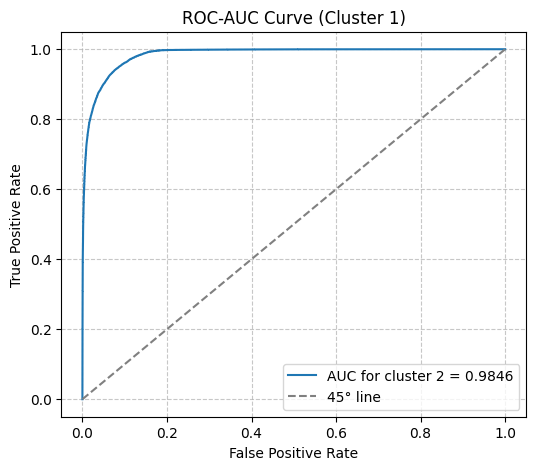

In [44]:
from sklearn.metrics import roc_auc_score, roc_curve

false_pos, true_pos, _ = roc_curve(y_test.values, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(6, 5))
plt.plot(false_pos, true_pos, label=f"AUC for cluster 2 = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='45° line')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve (Cluster 1)')
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

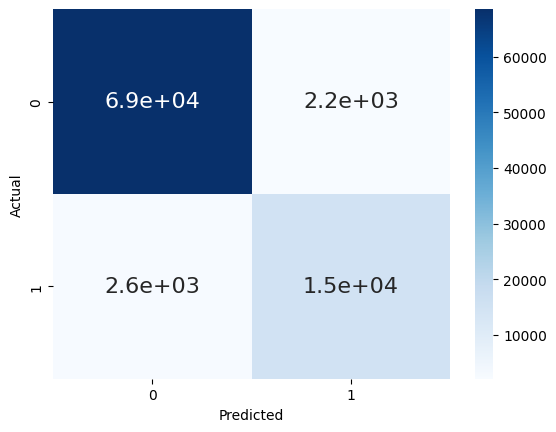

In [45]:
import numpy as np

df_cm= pd.DataFrame(confusion_matrix(y_test, y_pred), columns=np.unique(y_test), index= np.unique(y_test))
df_cm.index.name= 'Actual'
df_cm.columns.name= 'Predicted'
sns.heatmap(df_cm, annot=True, cmap='Blues', annot_kws={"size":16});

In [47]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97     70717
           1       0.87      0.85      0.86     17469

    accuracy                           0.95     88186
   macro avg       0.92      0.91      0.91     88186
weighted avg       0.95      0.95      0.95     88186



In [48]:
from sklearn.metrics import recall_score, precision_score, f1_score
print(recall_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.851794607590589
0.8728808588021353
0.8622088306872175


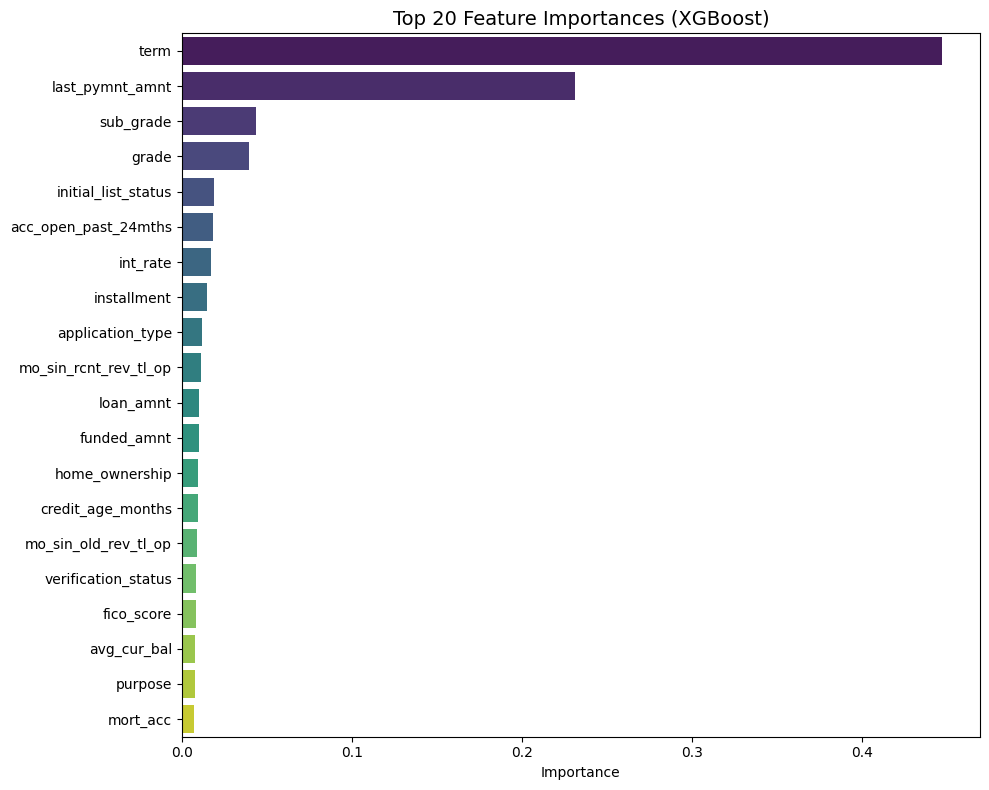

In [52]:
feature_names = model.named_steps['preprocessor'].get_feature_names_out()

xgb_model = model.named_steps['model']
importances = xgb_model.feature_importances_

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

feat_imp_df['Feature'] = (
    feat_imp_df['Feature']
    .str.replace(r'^(cat__|remainder__)', '', regex=True)
)

feat_imp_df['Feature'] = (
    feat_imp_df['Feature']
    .str.replace(r'^(num__|remainder__)', '', regex=True)
)
plt.figure(figsize=(10, 8))
sns.barplot(
    data=feat_imp_df.head(20),
    y='Feature',
    x='Importance',
    palette='viridis',
    hue='Feature',
    legend=False
)
plt.title('Top 20 Feature Importances (XGBoost)', fontsize=14)
plt.xlabel('Importance')
plt.ylabel('')
plt.tight_layout()
plt.show()